# Model Validation Notebook

This notebook provides a comprehensive validation for all implemented time series generative models (parametric and non-parametric). It covers the entire pipeline from data preprocessing to model training and synthetic data generation, ensuring that each model functions as expected and produces output in the desired format `(R, l, N)`.

## Table of Contents:
1.  [Setup and Imports](#Setup-and-Imports)
2.  [Data Preprocessing](#Data-Preprocessing)
3.  [Parametric Model Validation](#Parametric-Model-Validation)
    *   [Geometric Brownian Motion](#Geometric-Brownian-Motion)
    *   [Ornstein-Uhlenbeck Process](#Ornstein-Uhlenbeck-Process)
    *   [Merton Jump Diffusion](#Merton-Jump-Diffusion)
    *   [Double Exponential Jump Diffusion](#Double-Exponential-Jump-Diffusion)
    *   [GARCH(1,1)](#GARCH-1-1)
    *   [Block Bootstrap](#Block-Bootstrap)
4.  [Non-Parametric Model Validation](#Non-Parametric-Model-Validation)
    *   [TimeGAN](#TimeGAN)
    *   [QuantGAN](#QuantGAN)
    *   [TimeVAE](#TimeVAE)



In [ ]:
import sys
import numpy as np
import torch
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
project_root = Path().resolve().parents[0]
sys.path.append(str(project_root))

print(f"Project root added to sys.path: {project_root}")

from src.utils.preprocessing_utils import (
    TimeSeriesDataset,
    create_dataloaders,
    preprocess_data
)

from src.utils.configs_utils import get_dataset_cfgs

from src.models.base.base_model import ParametricModel, DeepLearningModel
from src.models.parametric.gbm import GeometricBrownianMotion
from src.models.parametric.ou_process import OUProcess
from src.models.parametric.merton_jump_diffusion import MertonJumpDiffusion
from src.models.parametric.garch11 import GARCH11
from src.models.parametric.de_jump_diffusion import DoubleExponentialJumpDiffusion

from src.models.non_parametric.block_bootstrap import BlockBootstrap
from src.models.non_parametric.time_gan import TimeGAN
from src.models.non_parametric.quant_gan import QuantGAN
from src.models.non_parametric.time_vae import TimeVAE

Project root added to sys.path: C:\Users\14165\Downloads\Unified-benchmark-for-SDGFTS-main
All necessary modules imported successfully!


## Data Preprocessing

This section demonstrates how to preprocess a sample dataset (`GOOG.csv`) using the provided utilities and create PyTorch `DataLoader` objects. This data will be used to train and validate our generative models.



In [2]:
nonparametric_cfg, parametric_cfg = get_dataset_cfgs()

In [3]:
# --- Normalized; Non-parametric case; Batched time series ---
print(f"Preprocessing normalized data with config: {nonparametric_cfg}")

train_data_np, valid_data_np, _ = preprocess_data(nonparametric_cfg)

batch_size = 32
train_loader_np, valid_loader_np, _ = create_dataloaders(
    train_data_np, valid_data_np, _,
    batch_size=batch_size,
    train_seed=42,
    valid_seed=42,
    num_workers=0,
    pin_memory=False
)

print(f"\n[Normalized] Train data shape: {train_data_np.shape}")
print(f"[Normalized] Valid data shape: {valid_data_np.shape}")
print(f"[Normalized] Number of training batches: {len(train_loader_np)}")
print(f"[Normalized] Number of validation batches: {len(valid_loader_np)}")

num_samples_real, length, num_channels = train_data_np.shape
print(f"\n[Normalized] Inferred model output dimensions: length={length}, num_channels={num_channels}")


Preprocessing normalized data with config: {'ticker': 'AAPL', 'original_data_path': 'C:\\Users\\14165\\Downloads\\Unified-benchmark-for-SDGFTS-main\\data\\raw\\AAPL\\AAPL.csv', 'valid_ratio': 0.1, 'test_ratio': 0.1, 'seed': 42}
Preprocessing data for AAPL

[Normalized] Train data shape: (9035, 13, 4)
[Normalized] Valid data shape: (1129, 13, 4)
[Normalized] Number of training batches: 283
[Normalized] Number of validation batches: 36

[Normalized] Inferred model output dimensions: length=13, num_channels=4


In [4]:
# --- Unnormalized; Parametric Case; Use full time series ---
print(f"Preprocessing full dataset with configs: {parametric_cfg}")

train_data_para, valid_data_para, _ = preprocess_data(parametric_cfg)

print(f"\n[Unnormalized] Type of train_data_para: {type(train_data_para)}")
print(f"[Unnormalized] Type of valid_data_para: {type(valid_data_para)}")
print(f"[Unnormalized] Train data shape: {train_data_para.shape}")
print(f"[Unnormalized] Valid data shape: {valid_data_para.shape}")

length, num_channels = train_data_para.shape
print(f"\n[Unnormalized] Inferred model output dimensions: length={length}, num_channels={num_channels}")

Preprocessing full dataset with configs: {'ticker': 'AAPL', 'original_data_path': 'C:\\Users\\14165\\Downloads\\Unified-benchmark-for-SDGFTS-main\\data\\raw\\AAPL\\AAPL.csv', 'valid_ratio': 0.1, 'test_ratio': 0.1, 'is_parametric': True, 'seed': 42}
Preprocessing data for AAPL

[Unnormalized] Type of train_data_para: <class 'torch.Tensor'>
[Unnormalized] Type of valid_data_para: <class 'torch.Tensor'>
[Unnormalized] Train data shape: torch.Size([9044, 4])
[Unnormalized] Valid data shape: torch.Size([1131, 4])

[Unnormalized] Inferred model output dimensions: length=9044, num_channels=4


## Stochastic Model Validation

This section validates the functionality of each stochastic time series generative model. For each model, we will:
1.  Instantiate the model with appropriate parameters.
2.  Train the model using the preprocessed training data.
3.  Generate new synthetic time series samples.
4.  Verify the shape and basic statistics of the generated data.



In [5]:

def plot_generated_vs_real(generated_data, num_generated_samples, length, valid_data_para):
    """
    Plots statistics and trajectories for generated samples against ground truth (valid_data_para).
    Assumes generated_data has financial channels:
      Channel 0: Open
      Channel 1: Close
      Channel 2: High
      Channel 3: Low

    Note:
        - Gray lines: each generated/simulated sample.
        - Blue line: ground truth from valid_data_para (first valid sequence).
    """
    channel_names = ["Open", "Close", "High", "Low"]
    num_channels = generated_data.shape[-1]
    assert num_channels == len(channel_names), f"Expected {len(channel_names)} channels, got {num_channels}"

    for c in range(num_channels):
        chan_data = generated_data[..., c]
        min_val = chan_data.min().item()
        max_val = chan_data.max().item()
        mean_val = chan_data.mean().item()
        print(f"{channel_names[c]} (channel {c}): min={min_val:.4f}, max={max_val:.4f}, mean={mean_val:.4f}")

        plt.figure(figsize=(12, 5))

        # First plot the blue line (real)
        if valid_data_para is not None:
            y_real = valid_data_para[:length, c]
            if hasattr(y_real, "detach"):
                y_real = y_real.detach().cpu().numpy()
            # Plot the real (blue) line first (will be under)
            plt.plot(
                range(length), y_real,
                alpha=0.95, linestyle="-", color='blue',
                label="Validation (True)"
            )

        # Then plot the generated gray lines OVER the blue line
        for i in range(num_generated_samples):
            y_fake = generated_data[i, :, c].cpu().numpy() if hasattr(generated_data, "cpu") else generated_data[i, :, c]
            plt.plot(
                range(length), y_fake,
                alpha=0.7, linestyle="--", color='gray',
                label="Generated" if i == 0 else None,
                zorder=3 # Give higher zorder to gray lines
            )

        plt.title(f"{channel_names[c]}: Generated vs Validation")
        plt.xlabel("Time Step")
        plt.ylabel(channel_names[c])
        plt.legend()
        plt.tight_layout()
        plt.show()



### Geometric Brownian Motion




Validating Geometric Brownian Motion (GBM)
GBM Model instantiated: <src.models.parametric.gbm.GeometricBrownianMotion object at 0x00000150412A0E60>
Fitting GBM model on full historical series...
Generated GBM forecast data shape: torch.Size([1, 9044, 4])
Open (channel 0): min=-0.1208, max=0.1144, mean=0.0007


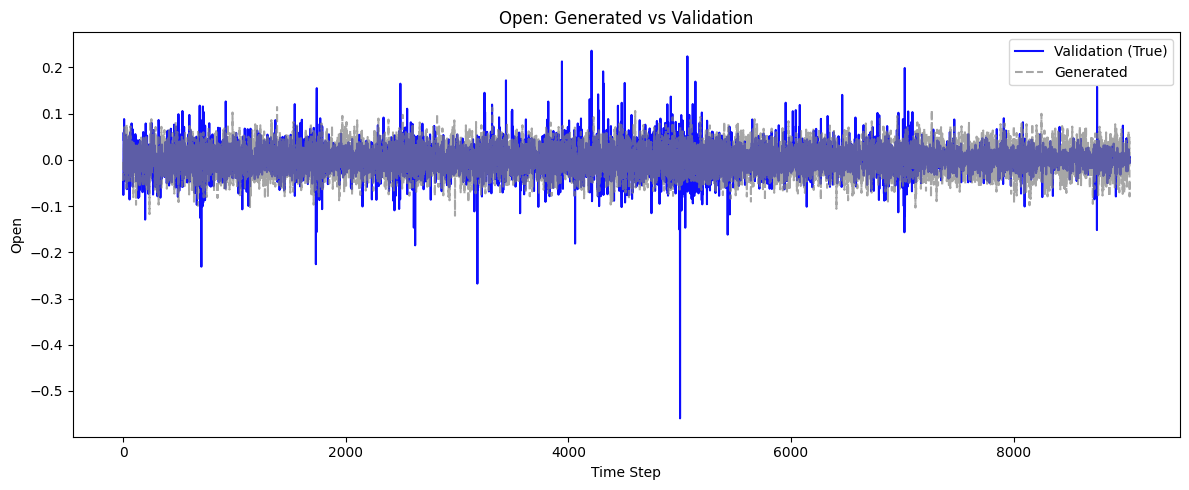

Close (channel 1): min=-0.1114, max=0.0965, mean=0.0010


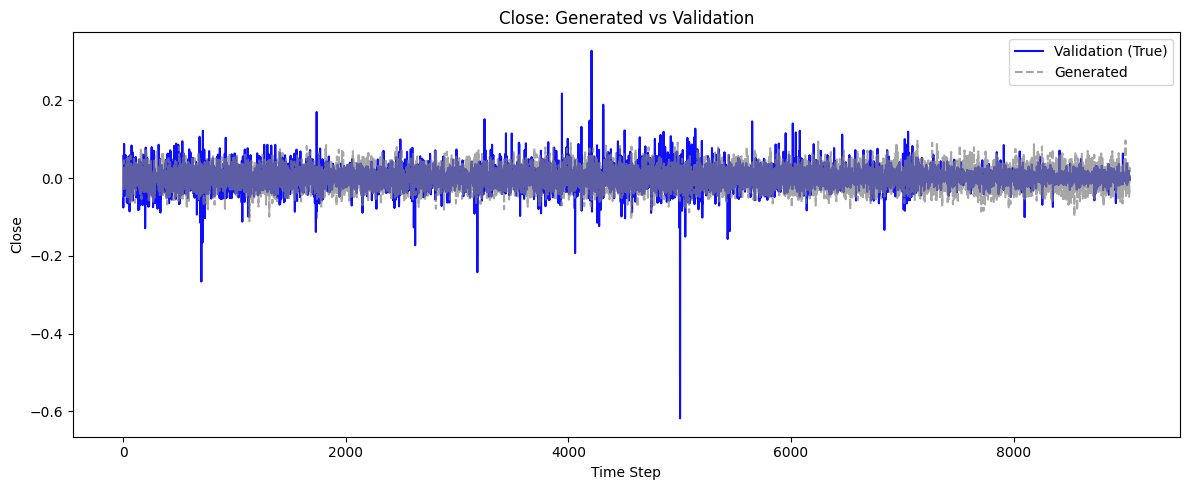

High (channel 2): min=-0.1039, max=0.1015, mean=0.0004


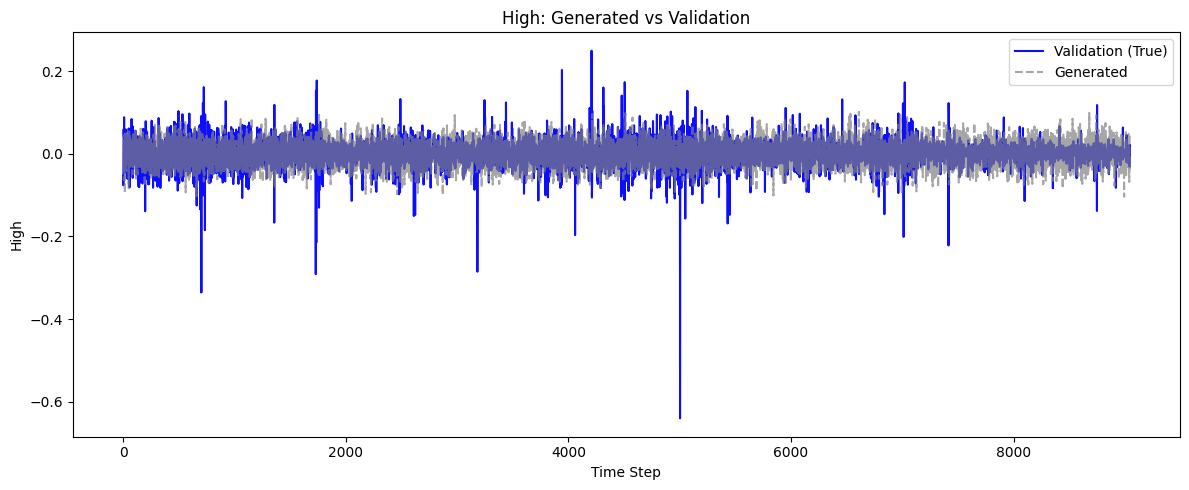

Low (channel 3): min=-0.1109, max=0.1194, mean=0.0004


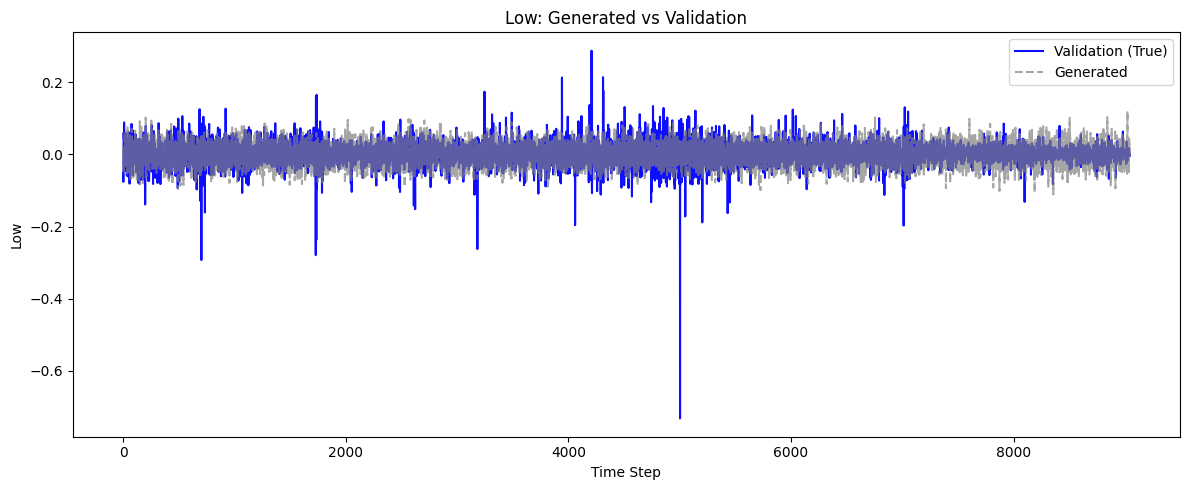

In [6]:
print("\n" + "=" * 50)
print("Validating Geometric Brownian Motion (GBM)")
print("=" * 50)

length, num_channels = train_data_para.shape
forecast_horizon = train_data_para.shape[0]

gbm_model = GeometricBrownianMotion(length=length, num_channels=num_channels)
print(f"GBM Model instantiated: {gbm_model}")

print("Fitting GBM model on full historical series...")
gbm_parameters = gbm_model.fit(train_data_para)

num_generated_samples = 1
gbm_generated_data = gbm_model.generate(
    num_samples=num_generated_samples,
    seq_length=forecast_horizon,
    seed=1
)
print(f"Generated GBM forecast data shape: {gbm_generated_data.shape}")
plot_generated_vs_real(gbm_generated_data, num_generated_samples, forecast_horizon, train_data_para)

### Ornstein-Uhlenbeck Process



In [7]:
print("\n" + "=" * 50)
print("Validating Ornstein-Uhlenbeck Process (OU)")
print("=" * 50)

length, num_channels = train_data_para.shape
forecast_horizon = train_data_para.shape[0]


ou_model = OUProcess(length=length, num_channels=num_channels)
print(f"OU Model instantiated: {ou_model}")

print("Fitting OU model on full historical series...")
ou_parameters = ou_model.fit(train_data_para)

num_generated_samples = 1
ou_generated_data = ou_model.generate(
    num_samples=num_generated_samples,
    seq_length=forecast_horizon,
    seed=42
)
print(f"Generated OU forecast data shape: {ou_generated_data.shape}")
plot_generated_vs_real(ou_generated_data, num_generated_samples, forecast_horizon, train_data_para)


Validating Ornstein-Uhlenbeck Process (OU)
OU Model instantiated: <src.models.parametric.ou_process.OUProcess object at 0x00000150415194F0>
Fitting OU model on full historical series...


KeyboardInterrupt: 

### Merton Jump Diffusion


Validating Merton Jump Diffusion (MJD)
MJD Model instantiated: <src.models.parametric.merton_jump_diffusion.MertonJumpDiffusion object at 0x000002807C434CE0>
Fitting MJD model on full historical series...
Generated MJD forecast data shape: (1, 9044, 4)
Open (channel 0): min=-0.3273, max=0.3545, mean=0.0011


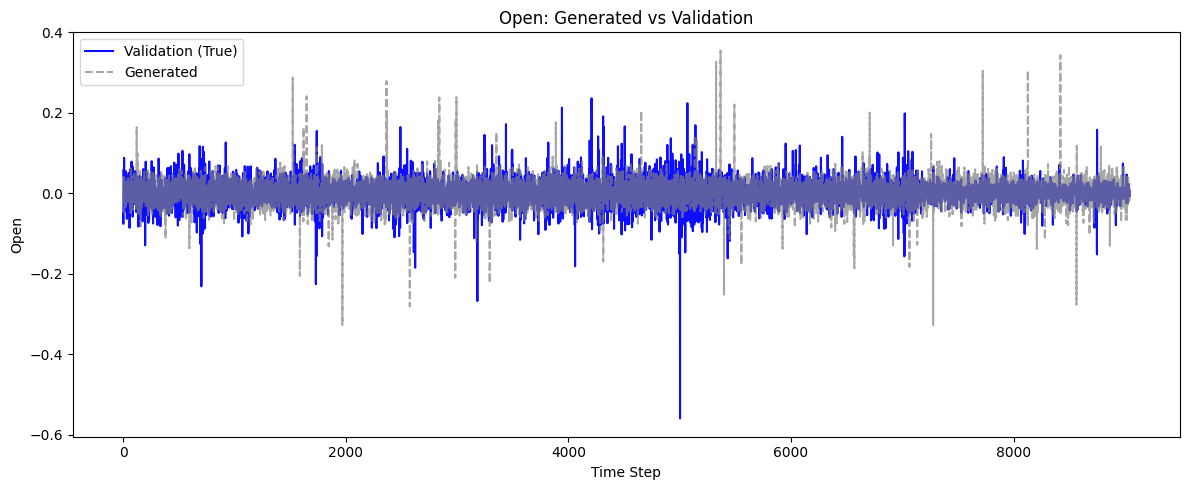

Close (channel 1): min=-0.3614, max=0.3319, mean=0.0005


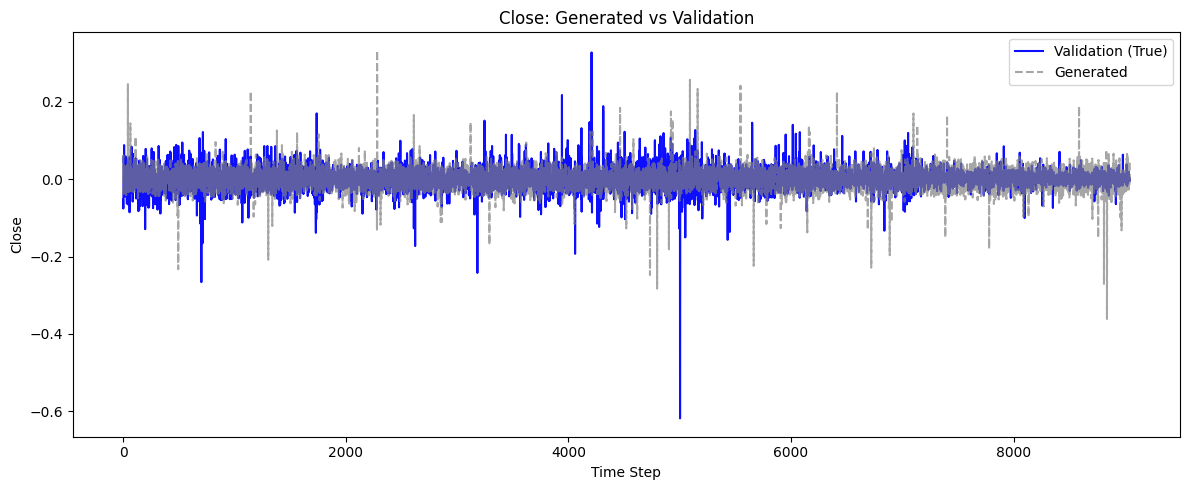

High (channel 2): min=-0.3470, max=0.3898, mean=0.0006


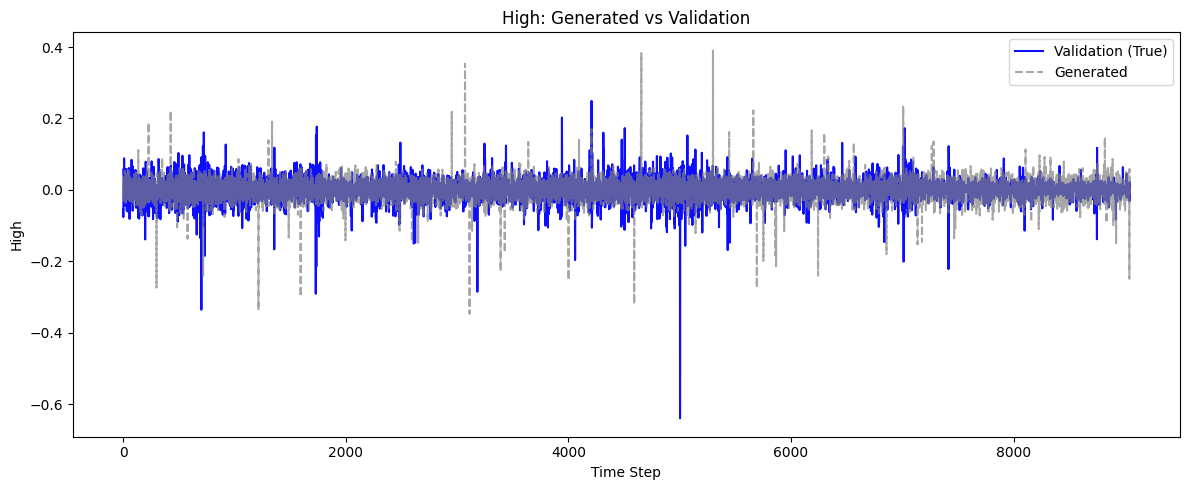

Low (channel 3): min=-0.3244, max=0.4084, mean=0.0008


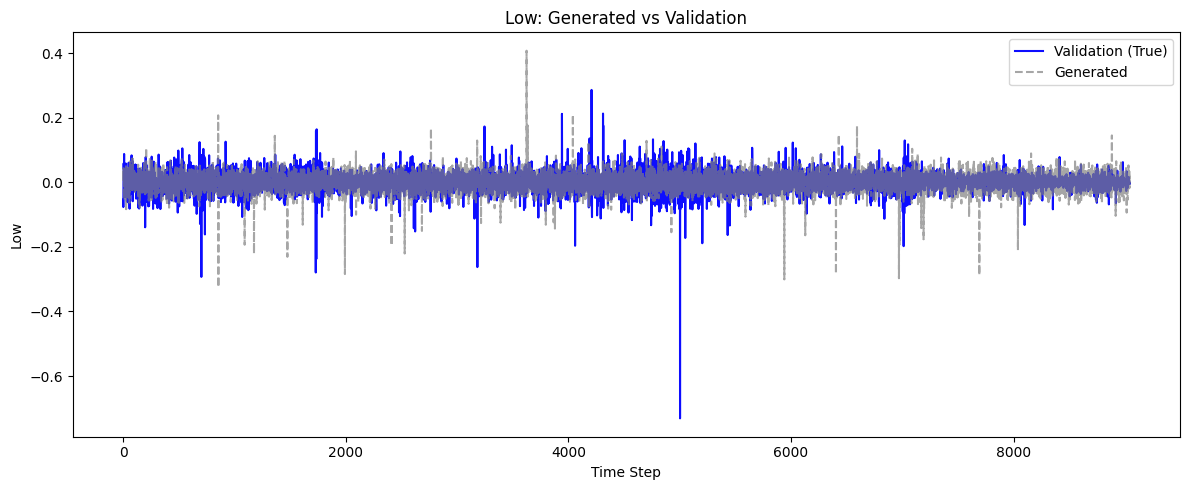

In [ ]:
print("\n" + "=" * 50)
print("Validating Merton Jump Diffusion (MJD)")
print("=" * 50)

length, num_channels = train_data_para.shape
forecast_horizon = train_data_para.shape[0]


mjd_model = MertonJumpDiffusion(length=length, num_channels=num_channels)
print(f"MJD Model instantiated: {mjd_model}")

print("Fitting MJD model on full historical series...")
mjd_parameters = mjd_model.fit(train_data_para)

num_generated_samples = 1
mjd_generated_data = mjd_model.generate(
    num_samples=num_generated_samples,
    seq_length=forecast_horizon,
    seed=42
)
print(f"Generated MJD forecast data shape: {mjd_generated_data.shape}")
plot_generated_vs_real(mjd_generated_data, num_generated_samples, forecast_horizon, train_data_para)

### GARCH(1, 1)


Validating GARCH(1,1)
GARCH(1,1) Model instantiated: <src.models.parametric.garch11.GARCH11 object at 0x000002807C8C1280>
Fitting GARCH(1,1) model on full historical series...
Generated GARCH(1,1) forecast data shape: torch.Size([1, 9044, 4])
Open (channel 0): min=-0.1741, max=0.2192, mean=0.0018


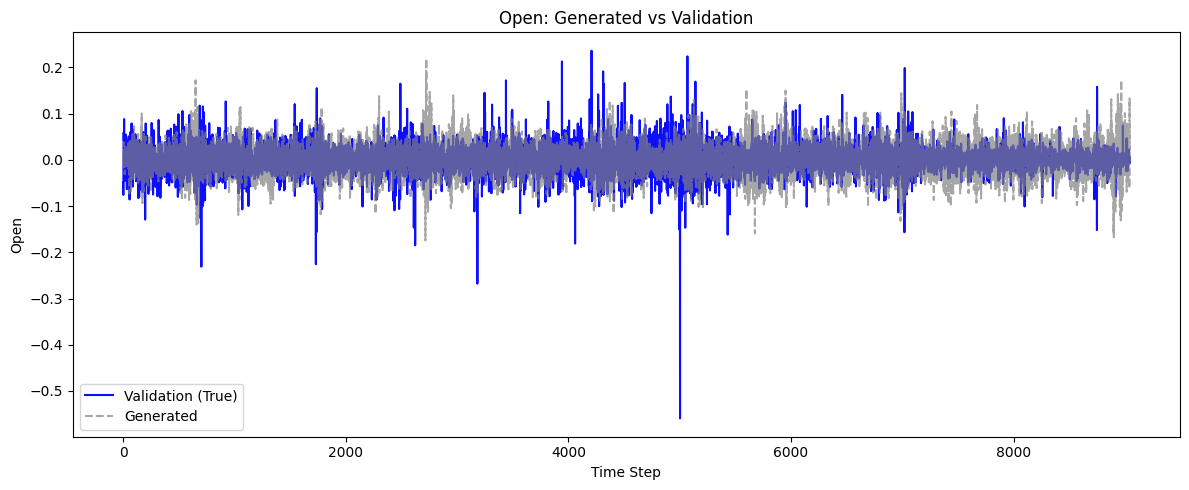

Close (channel 1): min=-0.2162, max=0.2162, mean=0.0010


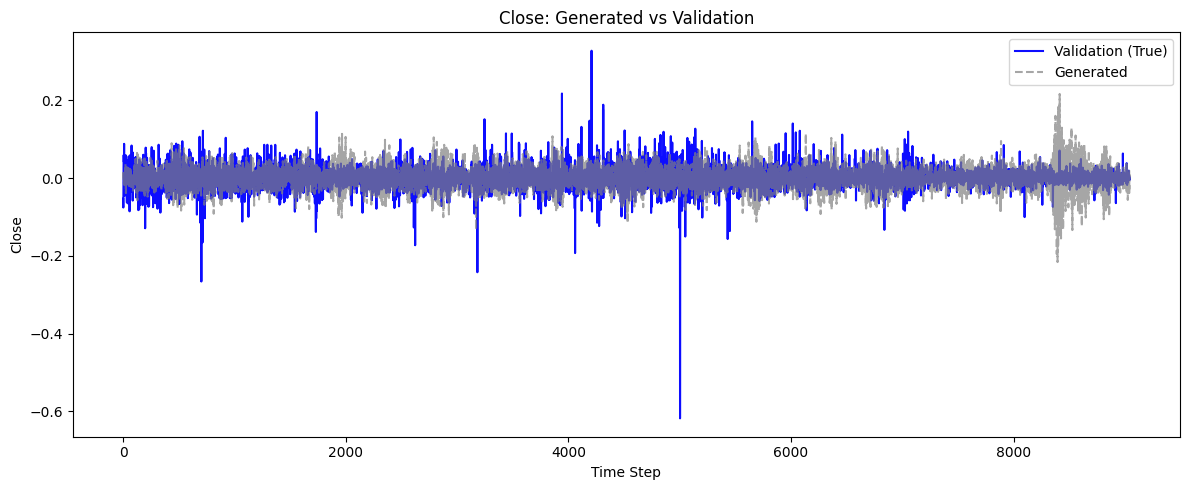

High (channel 2): min=-0.1164, max=0.1311, mean=0.0019


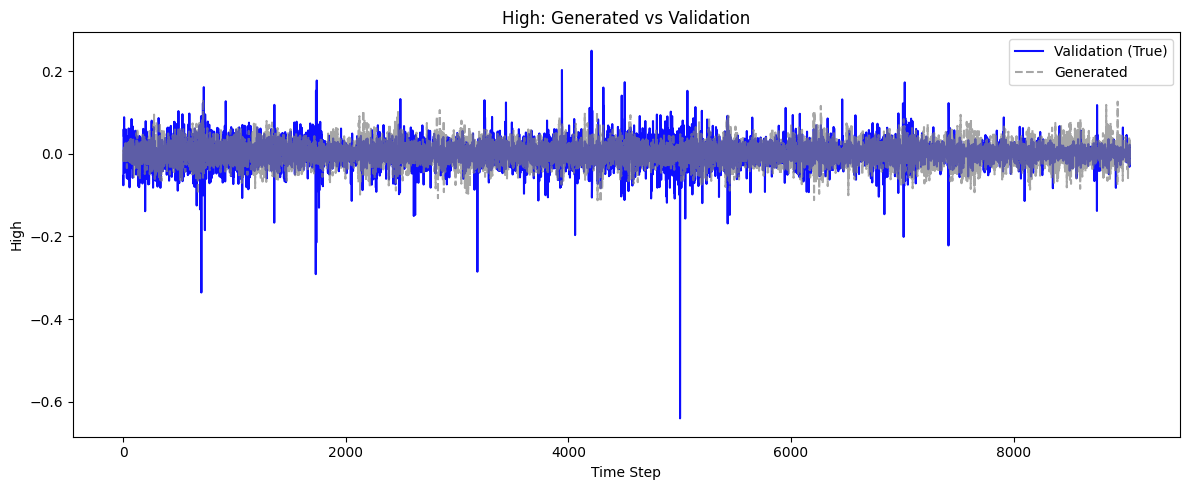

Low (channel 3): min=-0.2463, max=0.3092, mean=0.0012


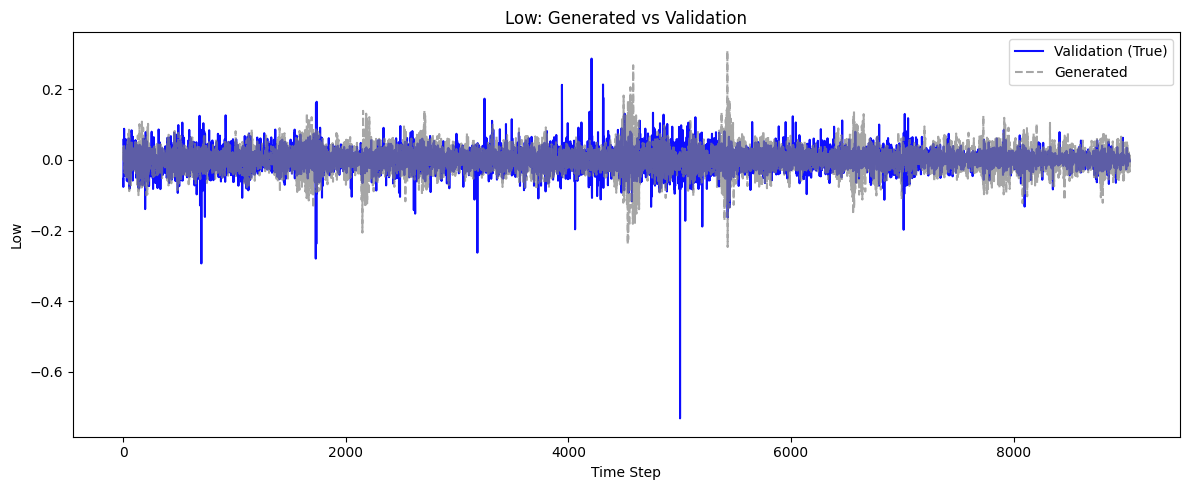

In [ ]:
print("\n" + "=" * 50)
print("Validating GARCH(1,1)")
print("=" * 50)

length, num_channels = train_data_para.shape
forecast_horizon = train_data_para.shape[0]

garch11_model = GARCH11(length=length, num_channels=num_channels)
print(f"GARCH(1,1) Model instantiated: {garch11_model}")

print("Fitting GARCH(1,1) model on full historical series...")
garch11_parameters = garch11_model.fit(train_data_para)

num_generated_samples = 1
garch11_generated_data = garch11_model.generate(
    num_samples=num_generated_samples,
    seq_length=forecast_horizon,
    seed=42
)
print(f"Generated GARCH(1,1) forecast data shape: {garch11_generated_data.shape}")
plot_generated_vs_real(garch11_generated_data, num_generated_samples, forecast_horizon, train_data_para)


### Double Exponential Jump Diffusion


Validating Double Exponential Jump Diffusion (DEJD)
DEJD Model instantiated: <src.models.parametric.de_jump_diffusion.DoubleExponentialJumpDiffusion object at 0x000002807CB60590>
Fitting DEJD model on full historical series...


C:\Users\14165\Downloads\Unified-benchmark-for-SDGFTS-main\src\models\parametric\de_jump_diffusion.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_returns = torch.tensor(log_returns, device=self.device)


Generated DEJD forecast data shape: torch.Size([1, 9044, 4])
Open (channel 0): min=-0.6189, max=0.6852, mean=0.0010


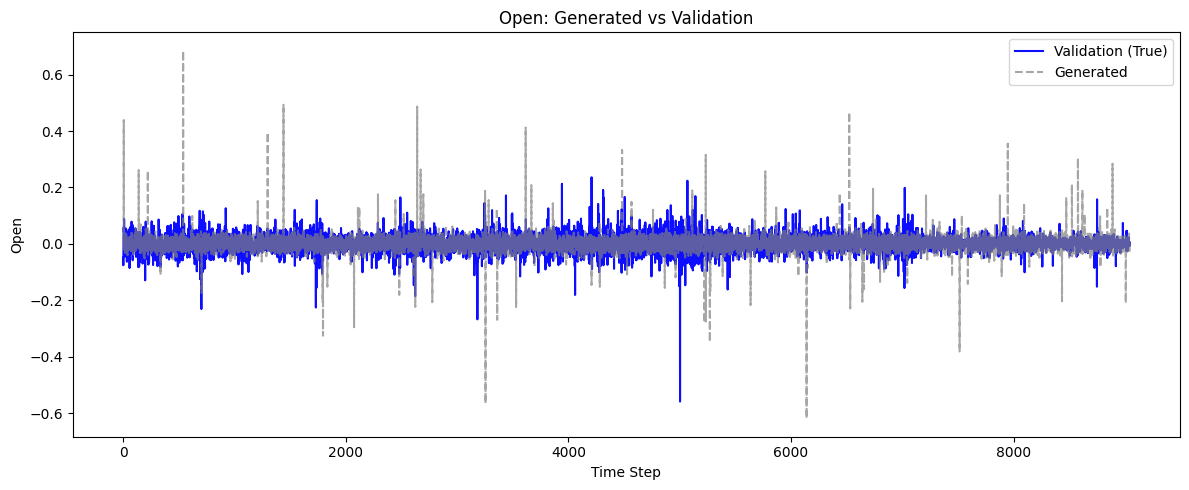

Close (channel 1): min=-0.6365, max=0.6005, mean=0.0004


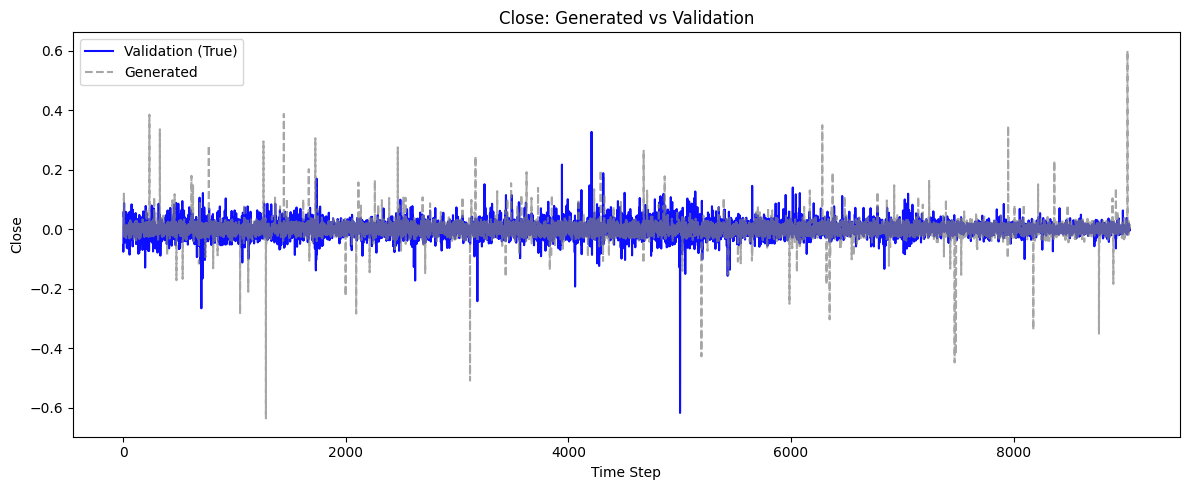

High (channel 2): min=-0.5131, max=0.6898, mean=0.0007


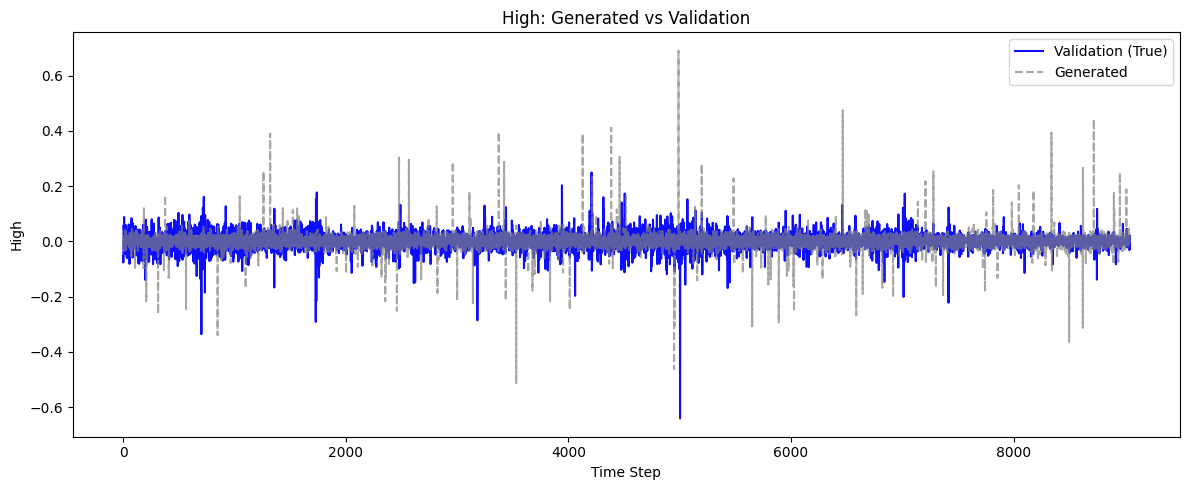

Low (channel 3): min=-0.6326, max=0.4852, mean=0.0007


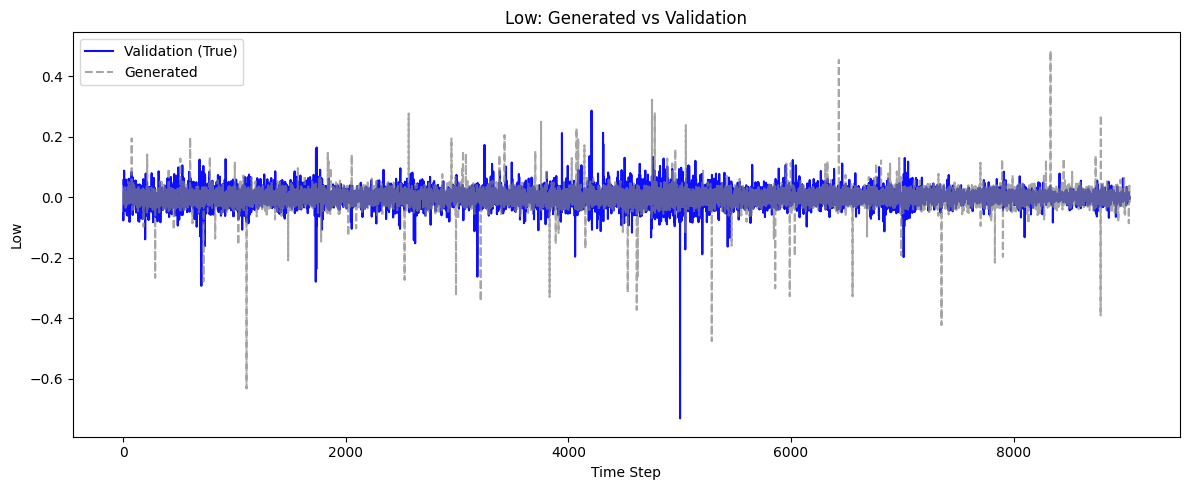

In [ ]:
print("\n" + "=" * 50)
print("Validating Double Exponential Jump Diffusion (DEJD)")
print("=" * 50)

length, num_channels = train_data_para.shape
forecast_horizon = train_data_para.shape[0]

dejd_model = DoubleExponentialJumpDiffusion(length=length, num_channels=num_channels)
print(f"DEJD Model instantiated: {dejd_model}")

print("Fitting DEJD model on full historical series...")
dejd_parameters = dejd_model.fit(train_data_para)

num_generated_samples = 1
dejd_generated_data = dejd_model.generate(
    num_samples=num_generated_samples,
    seq_length=forecast_horizon,
    seed=42
)
print(f"Generated DEJD forecast data shape: {dejd_generated_data.shape}")
plot_generated_vs_real(dejd_generated_data, num_generated_samples, forecast_horizon, train_data_para)

### Block Bootstrap


Validating Block Bootstrap Model
Block Bootstrap instantiated: <src.models.non_parametric.block_bootstrap.BlockBootstrap object at 0x000002807CD25AC0>
Fitting Block Bootstrap model on full historical series (train_data_para)...
Generated Block Bootstrap forecast data shape: torch.Size([1, 9044, 4])
Open (channel 0): min=-0.2677, max=0.2362, mean=0.0014


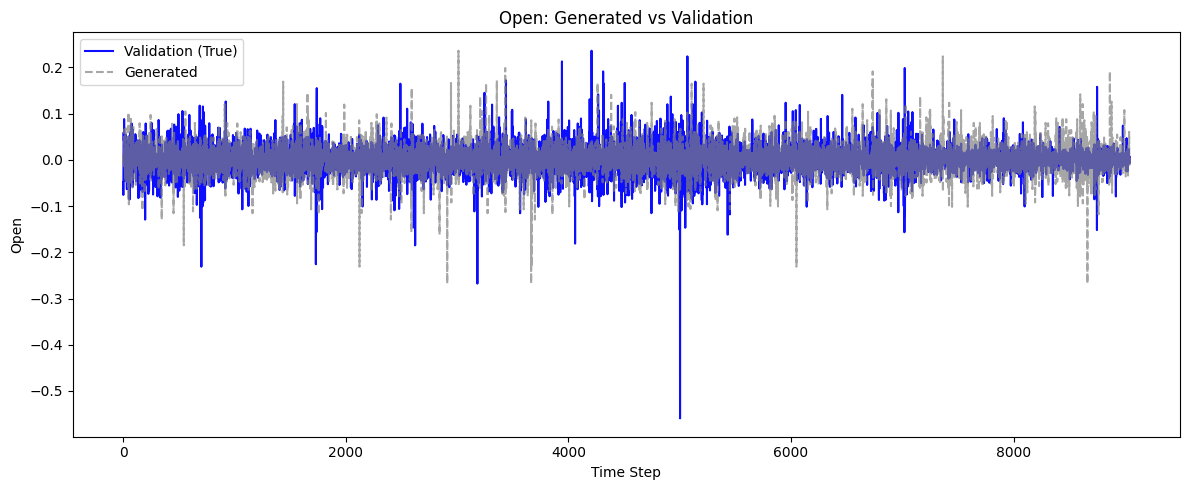

Close (channel 1): min=-0.2424, max=0.3275, mean=0.0003


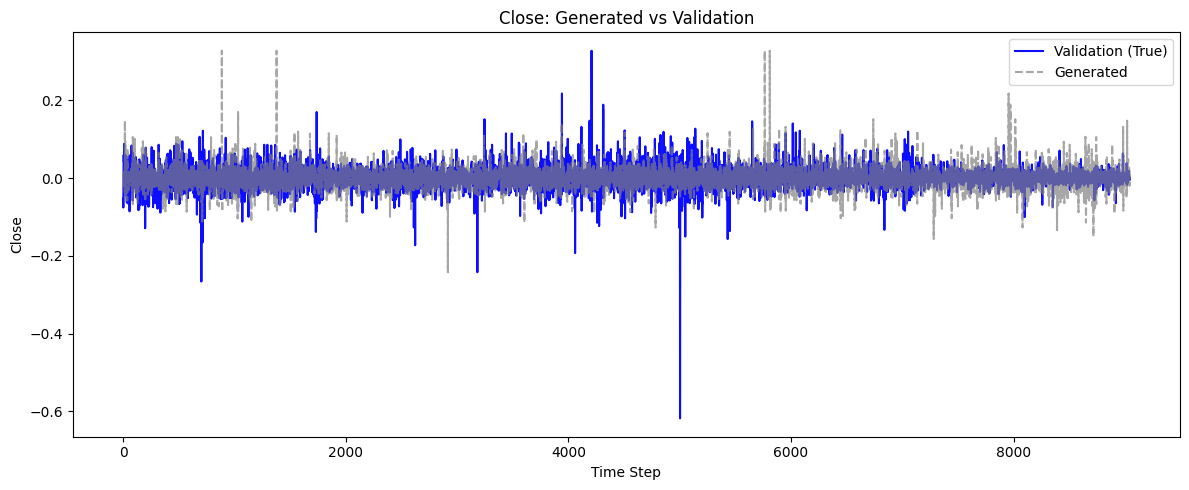

High (channel 2): min=-0.2912, max=0.2493, mean=0.0005


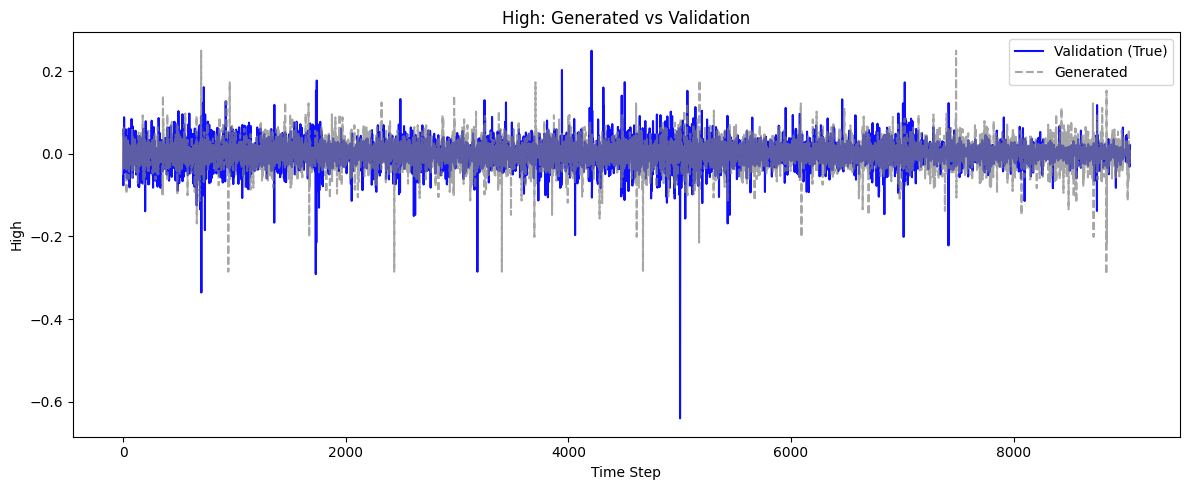

Low (channel 3): min=-0.7312, max=0.2869, mean=-0.0002


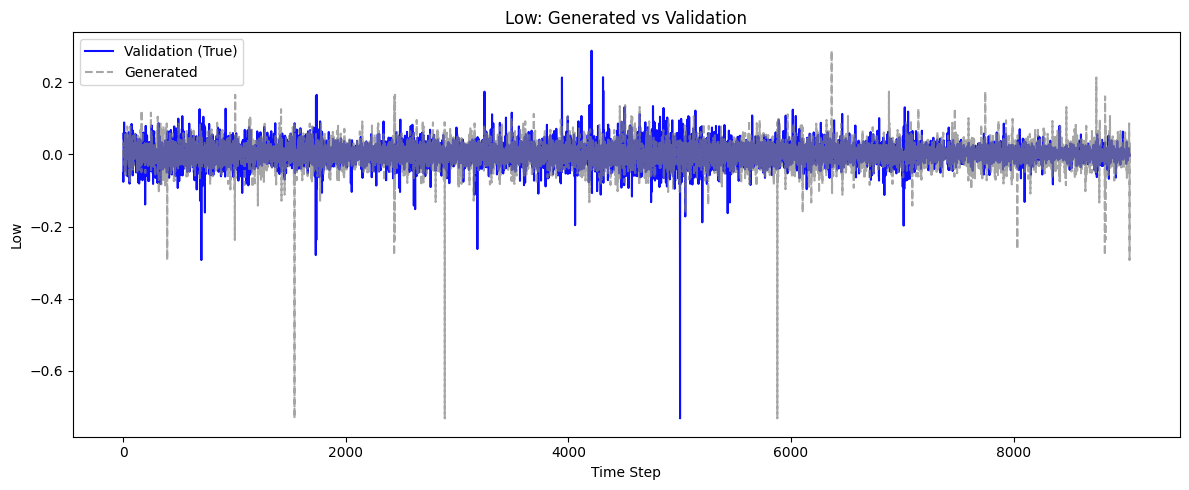

In [ ]:
print("\n" + "=" * 50)
print("Validating Block Bootstrap Model")
print("=" * 50)

L_train, N = train_data_para.shape
L_valid = train_data_para.shape[0]

block_size = 13
num_realizations = 1

# Instantiate and fit Block Bootstrap
bootstrap_model = BlockBootstrap(block_size=block_size)
print(f"Block Bootstrap instantiated: {bootstrap_model}")
print(f"Fitting Block Bootstrap model on full historical series (train_data_para)...")
bootstrap_model.fit(train_data_para)

# Generate forecast samples
generated_samples = bootstrap_model.generate(
    num_samples=num_realizations,
    seq_length=L_valid,
    seed=42
)
print(f"Generated Block Bootstrap forecast data shape: {generated_samples.shape}")

# Plot generated vs real
plot_generated_vs_real(generated_samples, num_realizations, L_valid, train_data_para)



## Deep Learning Model Validation

This section validates the functionality of each deep learning time series generative model. For each model, we will:
1.  Instantiate the model with appropriate parameters.
2.  Train the model using the preprocessed training data.
3.  Generate new synthetic time series samples.
4.  Verify the shape and basic statistics of the generated data.

Note: GAN training can be unstable and convergence is not guaranteed with simple validation. This is primarily to check code execution and output format.



In [4]:
def plot_model_simulations_mean_dt(
    model,
    num_simulations=10, 
    sequence_length=100, 
    feature_idx=None
):
    """
    Generate and plot multiple deep learning model simulations on uniform linear time steps.
    Supports any model that implements a .generate(num_samples, seq_length=...) method and
    outputs tensors of shape (R, l, N).
    """
    if hasattr(model, "eval"):
        model.eval()

    times = np.arange(sequence_length)
    sims = []

    for _ in range(num_simulations):
        with torch.no_grad():
            fake_series = model.generate(num_samples=1, seq_length=sequence_length)
        if isinstance(fake_series, torch.Tensor):
            fake_series = fake_series.cpu().numpy()
        fake_series = fake_series[0]
        sims.append(fake_series)

    sims = np.stack(sims, axis=0)
    num_channels = sims.shape[2]

    if feature_idx is None:
        channels_to_plot = range(num_channels)
    else:
        if feature_idx >= num_channels:
            raise ValueError(f"feature_idx={feature_idx} out of bounds for {num_channels} channels")
        channels_to_plot = [feature_idx]

    for ch in channels_to_plot:
        plt.figure(figsize=(12, 6))
        for i in range(num_simulations):
            plt.plot(times, sims[i, :, ch], label=f'Sim {i+1}', alpha=0.7)
        plt.title(f'{num_simulations} Model Simulations (Channel {ch})')
        plt.xlabel("Time Index")
        plt.ylabel("Feature Value (Normalized)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


### TimeGAN



In [ ]:
seq_length = train_data_np.shape[1]
num_channels = train_data_np.shape[2]

print("\n" + "=" * 50)
print("Training TimeGAN")
print("=" * 50)

time_gan = TimeGAN(
    length=seq_length,
    num_channels=num_channels,
)

print(f"TimeGAN model initialized on device: {time_gan.device}")

print("Training TimeGAN model...")
time_gan.fit(train_loader_np, num_epochs=3)
print("TimeGAN training complete.")



Training TimeGAN
TimeGAN model initialized on device: cpu
Training TimeGAN model...
TimeGAN epoch 1/3
TimeGAN epoch 2/3
TimeGAN epoch 3/3
TimeGAN training complete.


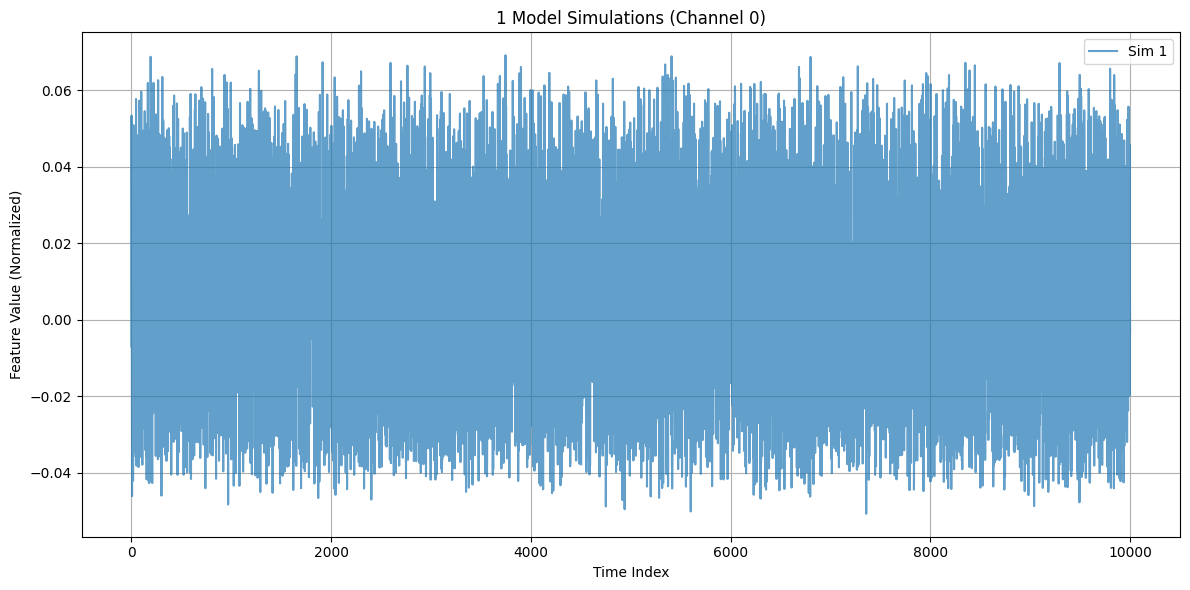

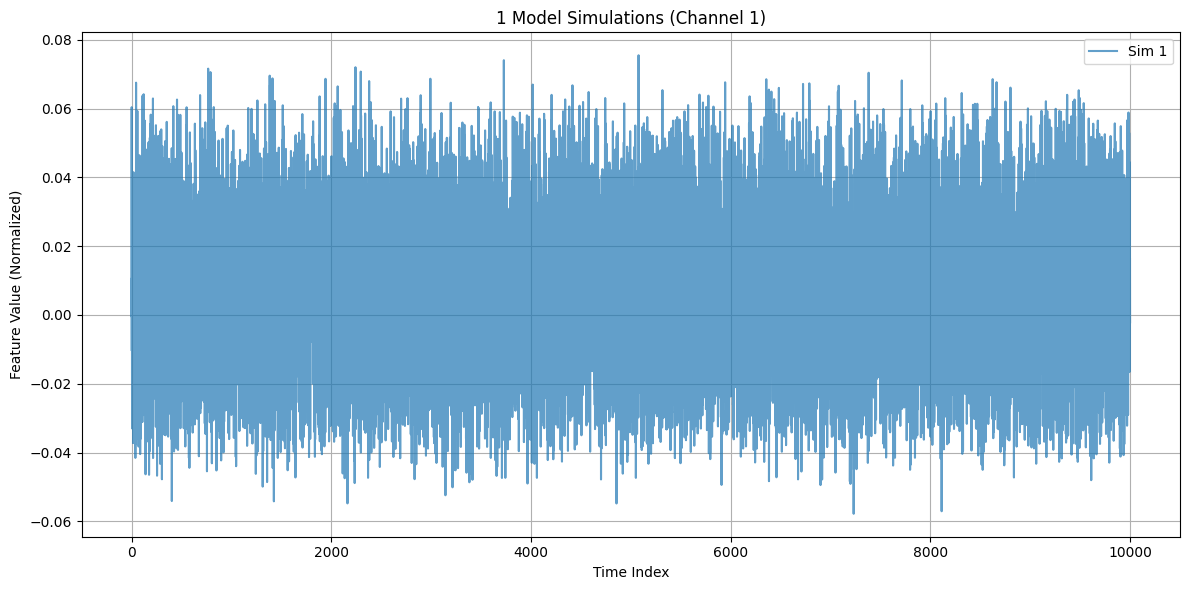

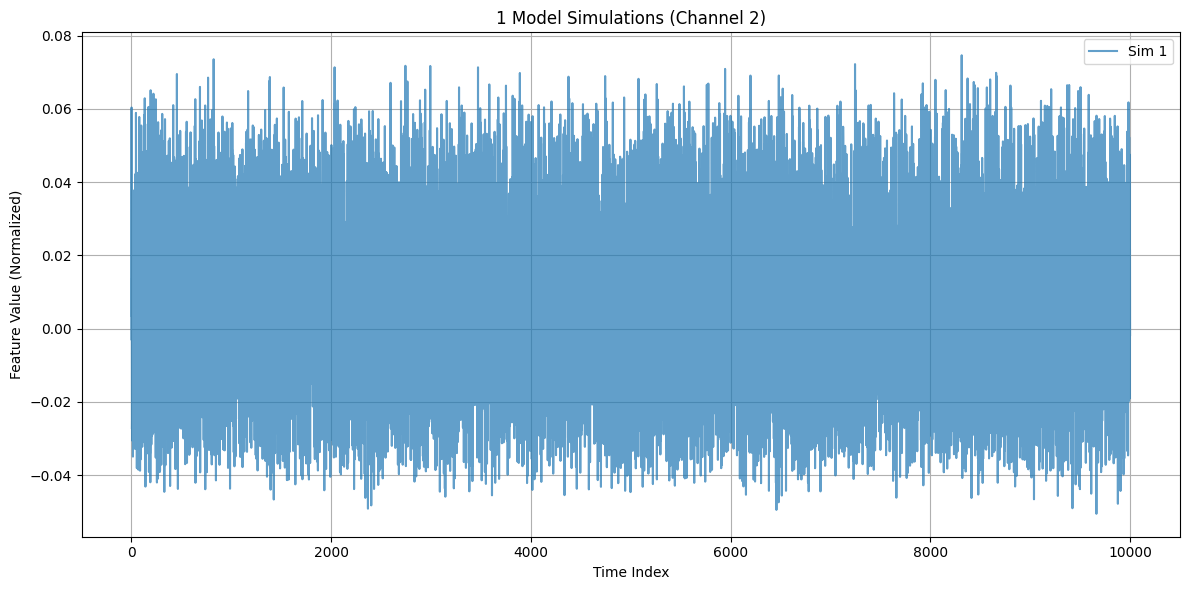

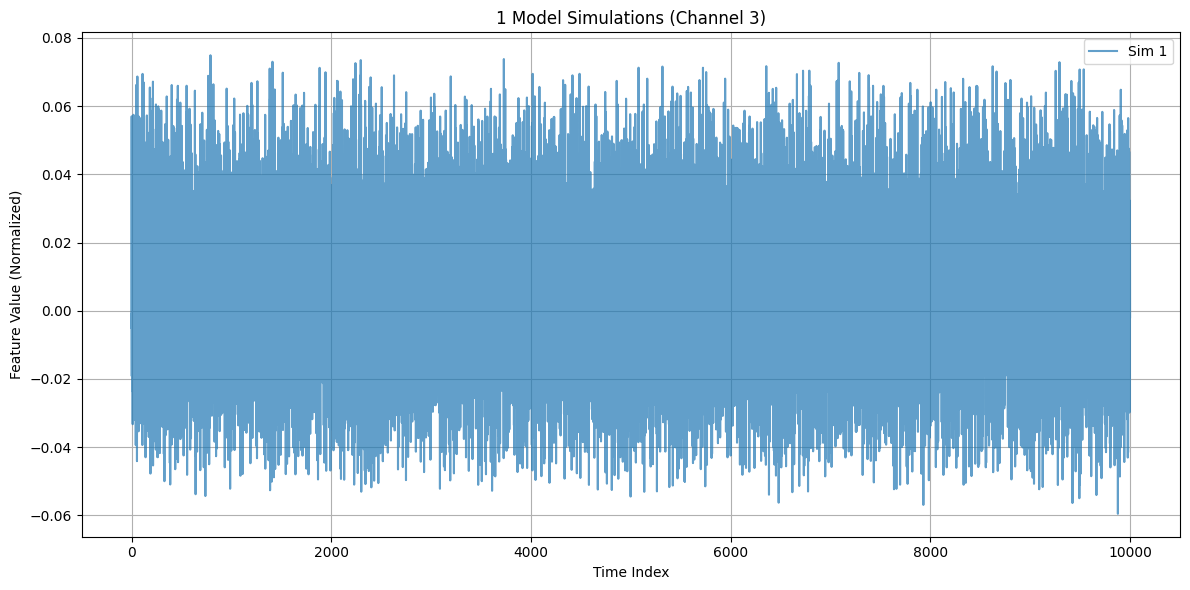

In [ ]:
plot_model_simulations_mean_dt(model=time_gan, num_simulations=1, sequence_length=10000)

### QuantGAN

In [ ]:
seq_length = train_data_np.shape[1]
num_channels = train_data_np.shape[2]

print("\n" + "=" * 50)
print("Training QuantGAN")
print("=" * 50)

quant_gan = QuantGAN(
    length=seq_length,
    num_channels=num_channels,
)

print(f"QuantGAN model initialized on device: {quant_gan.device}")

print("Training QuantGAN model...")
quant_gan.fit(train_loader_np, num_epochs=10)
print("QuantGAN training complete.")


Training QuantGAN
QuantGAN model initialized on device: cpu
Training QuantGAN model...
QuantGAN epoch 1/10
QuantGAN epoch 2/10
QuantGAN epoch 3/10
QuantGAN epoch 4/10
QuantGAN epoch 5/10
QuantGAN epoch 6/10
QuantGAN epoch 7/10
QuantGAN epoch 8/10
QuantGAN epoch 9/10
QuantGAN epoch 10/10
QuantGAN training complete.


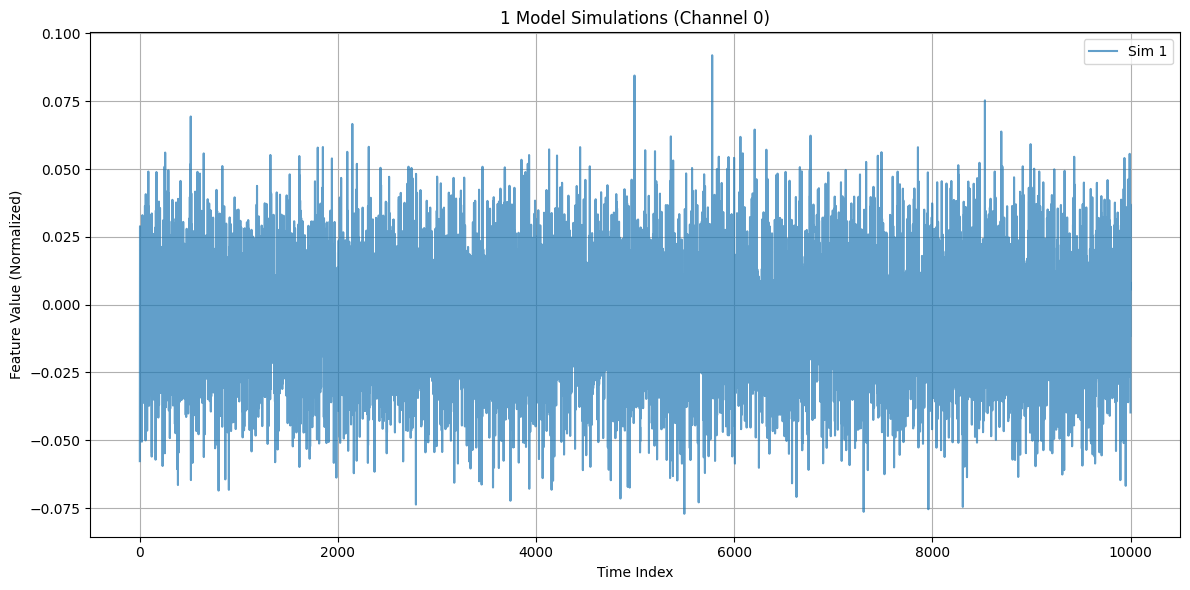

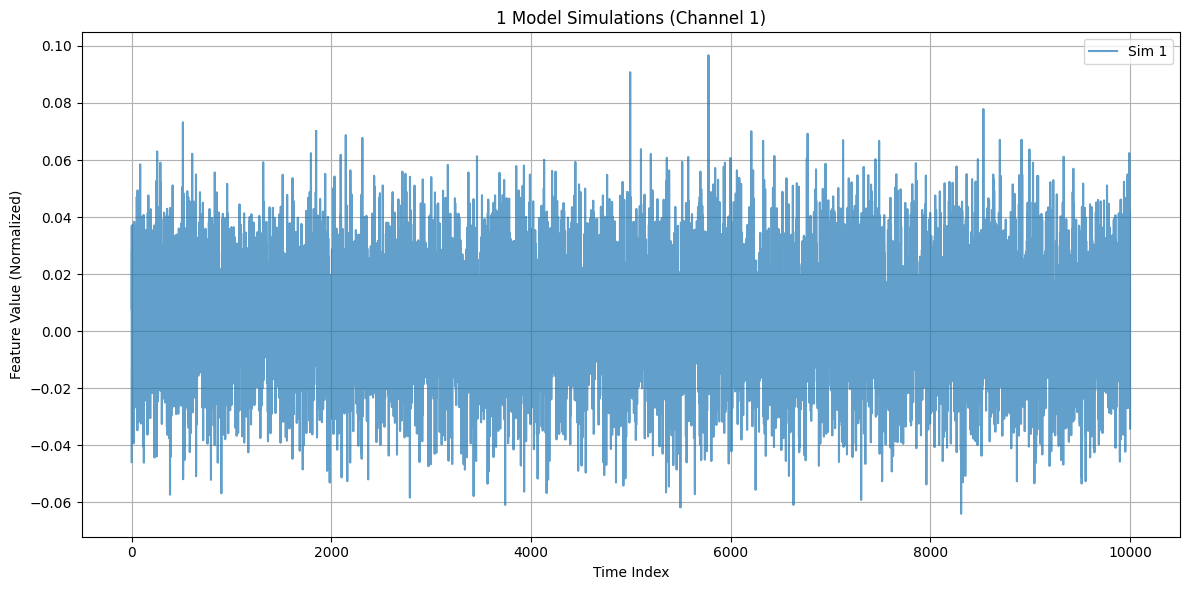

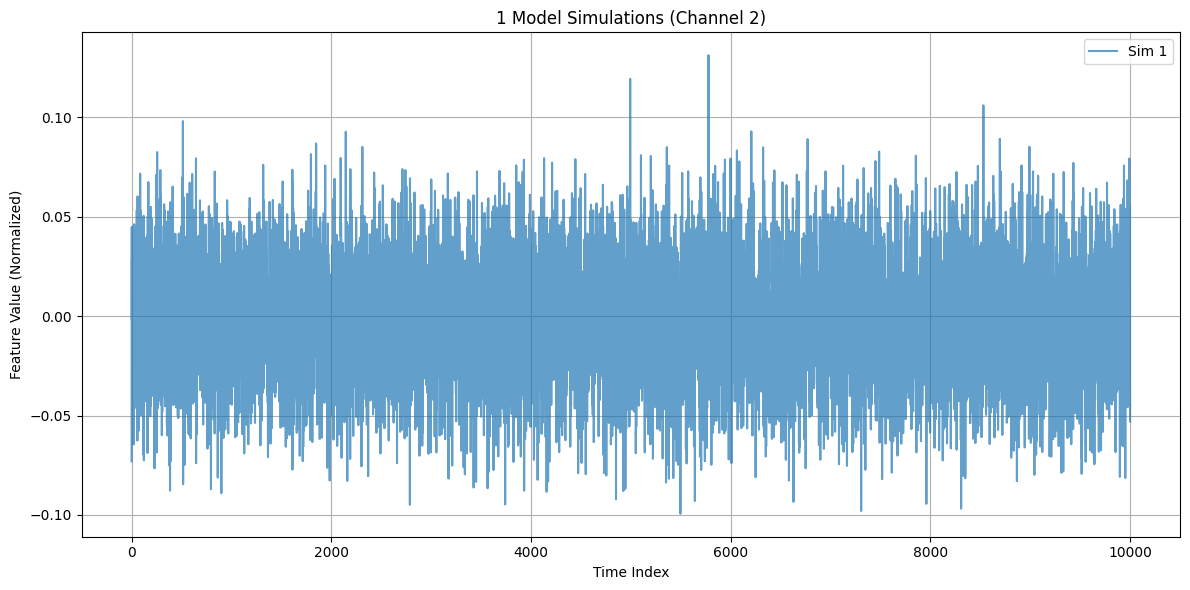

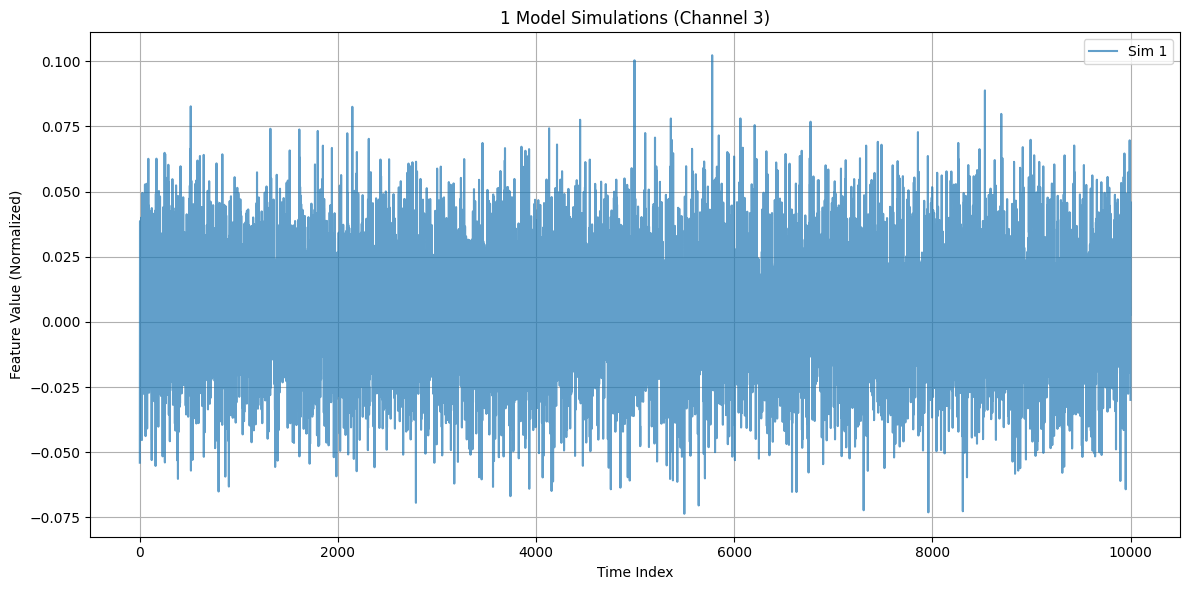

In [ ]:
plot_model_simulations_mean_dt(model=quant_gan, num_simulations=1, sequence_length=10000)

### TimeVAE

In [5]:
seq_length = train_data_np.shape[1]
num_channels = train_data_np.shape[2]

print("\n" + "=" * 50)
print("Training TimeVAE")
print("=" * 50)

time_vae = TimeVAE(
    length=seq_length,
    num_channels=num_channels,
)

print(f"TimeVAE model initialized on device: {time_vae.device}")

print("Training TimeVAE model...")
time_vae.fit(train_loader_np, num_epochs=10)
print("TimeVAE training complete.")


Training TimeVAE


TimeVAE model initialized on device: cpu
Training TimeVAE model...
TimeVAE training complete.


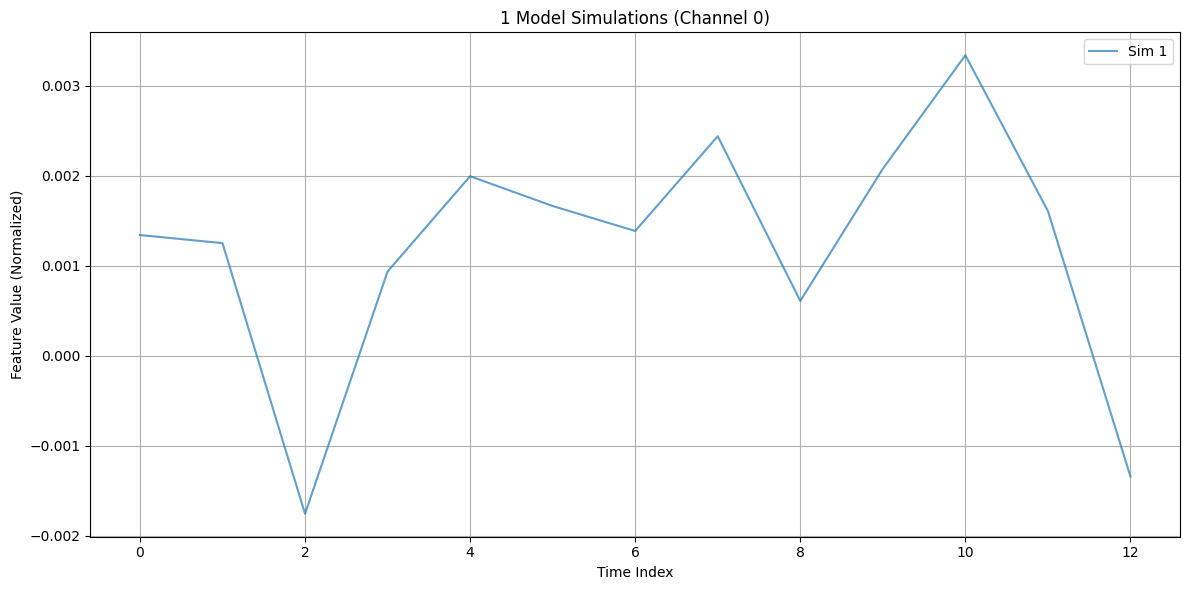

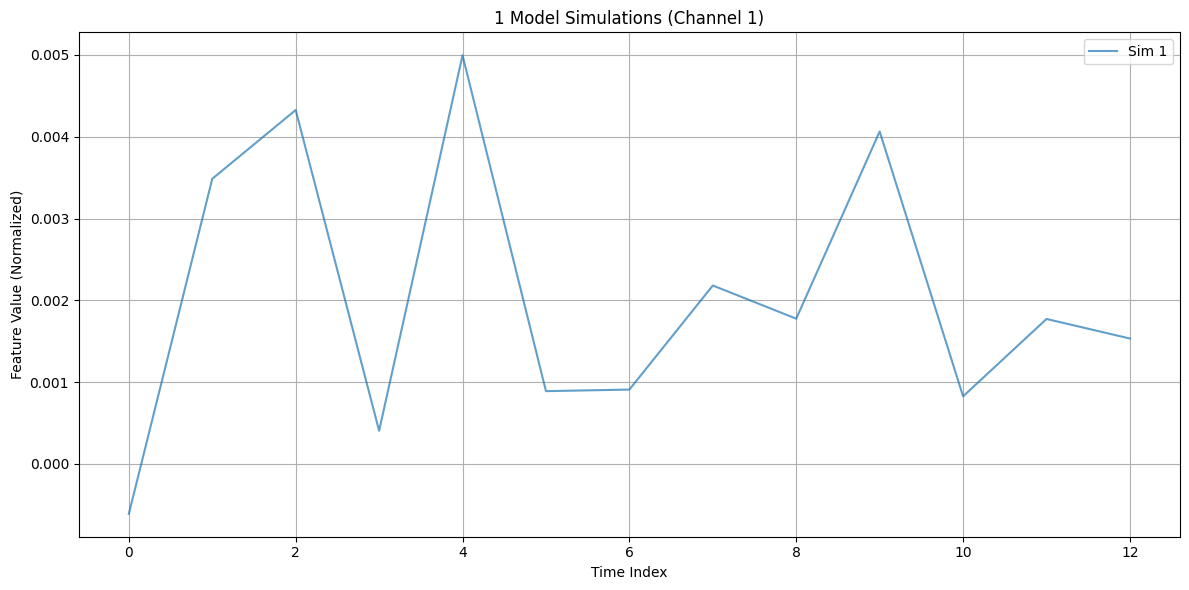

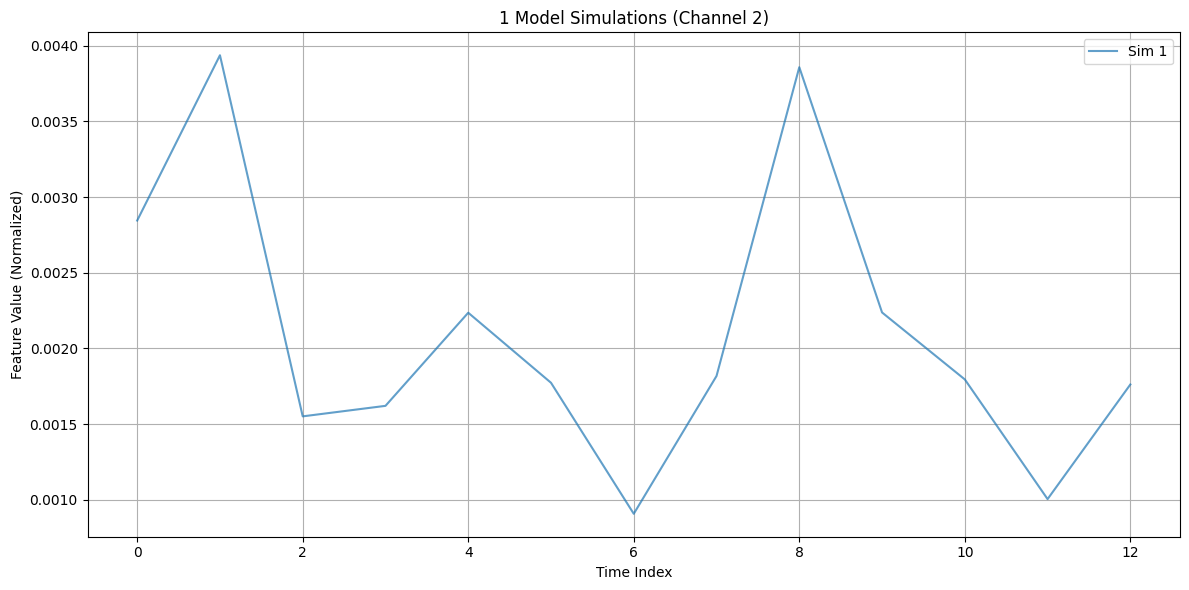

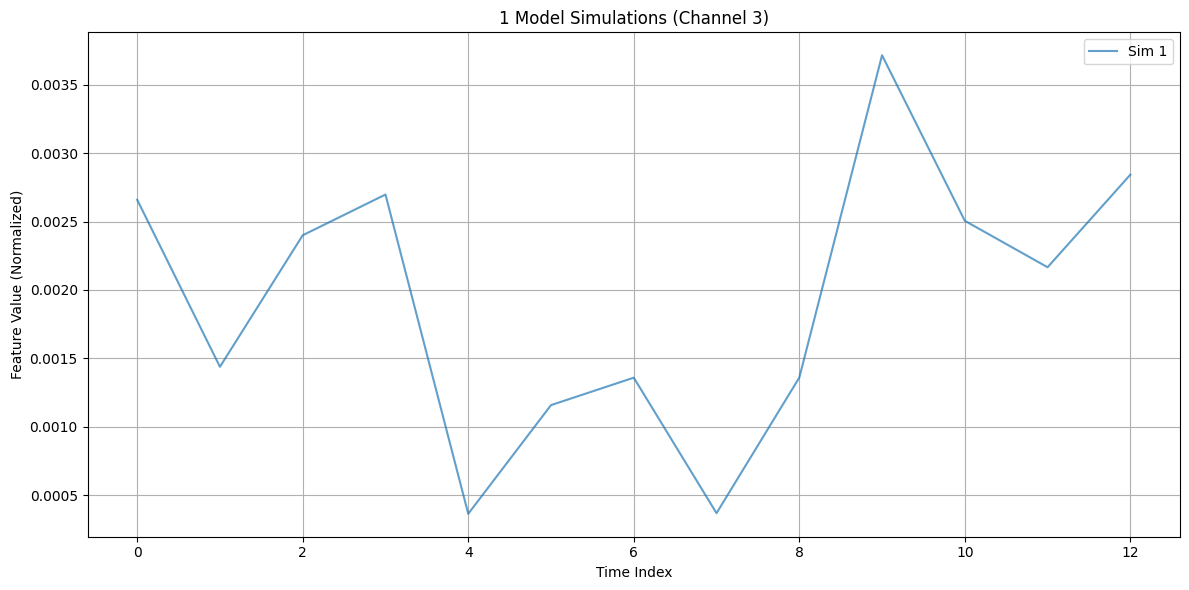

In [7]:
plot_model_simulations_mean_dt(model=time_vae, num_simulations=1, sequence_length=13)